In [21]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization

# Loading the Data

### Defining general functions

In [34]:
# Function to split a single song into overlapping windows of the same
import more_itertools as it_plus

# def split_window(arr, genre, chunk_size=0.1, step_size=1):
    
#     # Get the window size
#     window_size = int(X.shape[0]*chunk_size)
#     final_arr_x = list(it_plus.windowed(X, n=window_size, step=step_size))
#     final_arr_y = [genre for x in range(len(final_arr_x))]
#     print(final_arr_x)
#     return np.array(final_arr_x), np.array(final_arr_y)

def split_window(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [33]:
#Function to convert songs into their respective Melspectograms
#https://github.com/Hguimaraes/gtzan.keras/blob/master/src/gtzan/struct.py

def to_melspec(song, n_fft=1024, hop_len=512):
    #Transform into spectograms
    melspec = lambda x: librosa.feature.melspectrogram(x,n_fft = n_fft,hop_length = hop_len)[:,:,np.newaxis]
    transformed_songs = map(melspec, song)
    return np.array(list(transformed_songs))

In [36]:
#https://github.com/Hguimaraes/gtzan.keras/blob/master/src/gtzan/struct.py

def read_data(src_dir, genres, song_samples, spec_format, chunk_size=0.1, step_size=1, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_specs = []
    arr_genres = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples]
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Convert to dataset of spectograms/melspectograms
                signals, y = split_window(signal, genres[x])
                
                # Convert to "spec" representation
                specs = spec_format(signals)
                
                # Save files
                arr_genres.extend(y)
                arr_specs.extend(specs)
                
                
    return np.array(arr_specs), np.array(arr_genres)

In [37]:
print(os.getcwd()+"/genres/")

E:\Work\Case Study\Music Classification/genres/


In [38]:
if not (os.path.isfile("x_gtzan_npy.npy") or os.path.isfile("y_gtzan_npy.npy")):
    # Parameters
    gtzan_dir = os.getcwd()+"/genres/"
    song_samples = 660000
    genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
              'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

    # Read the data
    X, y = read_data(gtzan_dir, genres, song_samples, to_melspec, debug=False)
    np.save('x_gtzan_npy.npy', X)
    np.save('y_gtzan_npy.npy', y)

In [41]:
X = np.load('x_gtzan_npy.npy')
y = np.load('y_gtzan_npy.npy')

## Building DL models

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [42]:
# One hot encoding of the labels
y = to_categorical(y)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)

### CNN

In [134]:
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, TimeDistributed, Input
from keras.layers.core import Dense, Dropout
import keras

In [151]:
# Model Definition
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
print(timesteps)
print(input_dim)
print(X_train.shape)
num_genres = 10

128
129
(13300, 128, 129, 1)


In [179]:
# inp_shape = Input(shape=X_train[0].shape)
# print(inp_shape)
# #Model 1
# model_1 = Conv2D(64,(4,4), padding='same', activation='relu')(inp_shape)
# model_1 = MaxPooling2D((2,2), strides=(1,1), padding='same')(model_1)
# model_1 = Dropout(0.5)(model_1)
# model_1 = Conv2D(128,(4,4), padding='same', activation='relu')(model_1)
# model_1 = MaxPooling2D((2,2), strides=(1,1), padding='same')(model_1)
# # model_1 = Flatten()(model_1)
# # model_1 = Dropout(0.8)(model_1)

# #Model 2
# model_2 = LSTM(64, kernel_initializer=keras.initializers.glorot_normal(seed=None), return_sequences=True)(inp_shape)
# model_2 = Dropout(0.8)(model_2)
# model_2 = LSTM(128, kernel_initializer=keras.initializers.glorot_normal(seed=None))(model_2)
# model_2 = Dropout(0.6)(model_2)
# merged = keras.layers.concatenate([model_1, model_2], axis=1)
# out = Dense(64, activation='relu')(merged)
# out = Dropout(0.7)(merged)
# out = Dense(num_genres, activation='softmax')(out)
# model = Model(input_shape, out)
# model.summary()
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [192]:
# Model Definition
input_shape = X_train[0].shape
num_genres = 10

model = Sequential()
# Conv Block 1
model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 4
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))

# Conv Block 5
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
model.add(Dropout(0.3))

# MLP
model.add(Flatten())
model.add(Dense(num_genres, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_127 (Conv2D)          (None, 126, 127, 16)      160       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 28, 28, 64)        18496     
__________

In [193]:
X_train[0].shape

(128, 129, 1)

In [194]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [195]:
hist1 = model.fit(X_train, y_train,
          batch_size=128,
          epochs=40,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 13300 samples, validate on 5700 samples
Epoch 1/40
13300/13300 [==============================] - 99s 7ms/step - loss: 2.3367 - acc: 0.1909 - val_loss: 2.1427 - val_acc: 0.2177
Epoch 2/40
13300/13300 [==============================] - 98s 7ms/step - loss: 2.0150 - acc: 0.2623 - val_loss: 1.9725 - val_acc: 0.2581
Epoch 3/40
13300/13300 [==============================] - 101s 8ms/step - loss: 1.8090 - acc: 0.3523 - val_loss: 1.7299 - val_acc: 0.3728
Epoch 4/40
13300/13300 [==============================] - 101s 8ms/step - loss: 1.6439 - acc: 0.4183 - val_loss: 1.5884 - val_acc: 0.4254
Epoch 5/40
13300/13300 [==============================] - 101s 8ms/step - loss: 1.5231 - acc: 0.4613 - val_loss: 1.4060 - val_acc: 0.5156
Epoch 6/40
13300/13300 [==============================] - 102s 8ms/step - loss: 1.4365 - acc: 0.4942 - val_loss: 1.4398 - val_acc: 0.4811
Epoch 7/40
13300/13300 [==============================] - 102s 8ms/step - loss: 1.3813 - acc: 0.5115 - val_loss: 1.3026 - val

Test score: 0.5945673463846508
Test accuracy: 0.8049122807017544


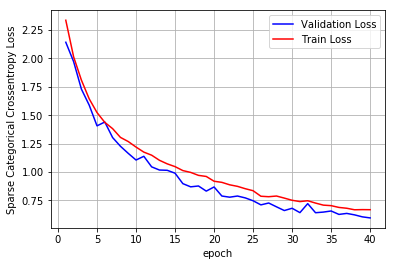

In [197]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])

print('Test accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Sparse Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,40+1))


vy = hist1.history['val_loss']
ty = hist1.history['loss']
plt_dynamic(x, vy, ty, ax)

### Iterating for another 10 epochs

In [198]:
hist2 = model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 13300 samples, validate on 5700 samples
Epoch 1/10
13300/13300 [==============================] - 96s 7ms/step - loss: 0.6364 - acc: 0.7912 - val_loss: 0.6080 - val_acc: 0.8140
Epoch 2/10
13300/13300 [==============================] - 96s 7ms/step - loss: 0.6333 - acc: 0.7910 - val_loss: 0.5942 - val_acc: 0.8126
Epoch 3/10
13300/13300 [==============================] - 99s 7ms/step - loss: 0.6286 - acc: 0.7886 - val_loss: 0.5597 - val_acc: 0.8193
Epoch 4/10
13300/13300 [==============================] - 97s 7ms/step - loss: 0.6219 - acc: 0.7922 - val_loss: 0.5445 - val_acc: 0.8218
Epoch 5/10
13300/13300 [==============================] - 96s 7ms/step - loss: 0.6211 - acc: 0.7890 - val_loss: 0.5967 - val_acc: 0.8107
Epoch 6/10
13300/13300 [==============================] - 98s 7ms/step - loss: 0.6103 - acc: 0.7923 - val_loss: 0.5545 - val_acc: 0.8195
Epoch 7/10
13300/13300 [==============================] - 98s 7ms/step - loss: 0.6137 - acc: 0.7938 - val_loss: 0.5537 - val_acc:

Test score: 0.5268087197186654
Test accuracy: 0.8278947368421052


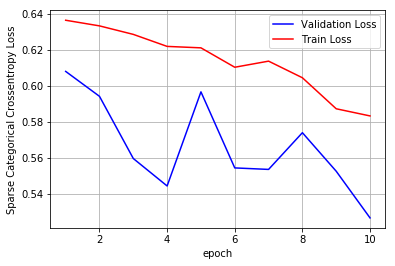

In [199]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])

print('Test accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Sparse Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))


vy = hist2.history['val_loss']
ty = hist2.history['loss']
plt_dynamic(x, vy, ty, ax)

In [200]:
model.save("music_genre_classn.h5")